<a href="https://colab.research.google.com/github/Aaryan-Agr/CanadianEnergy/blob/main/CP321_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Loading Data
import pandas as pd
import matplotlib.pyplot as plt
import requests

url = r'https://www.neb-one.gc.ca/open/imports-exports/imports-exports-data-visualization.csv'
df = pd.read_csv(url,encoding='ISO-8859-1')

In [ ]:
# Filtering out specific transactional activities and confidential values
clean = (~df.iloc[:,7].isin(['Export / Re-imports' ,'Import / Re-exports','Re-export / Imports' ,'Re-import / Exports']))&(df.iloc[:,-1]!="Confidential")
dfIE = df[clean].copy()


#Segmenting, Arranging and Mutating columns
dfIE[['Year','Quarter']] = dfIE['Period'].str.split('Q', expand = True)
dfIE.drop(columns=['Period'], inplace=True)
dfIE.insert(0, 'Year', dfIE.pop('Year'))
dfIE.insert(1, 'Quarter', dfIE.pop('Quarter'))

dfIE['Value'] = pd.to_numeric(dfIE['Value'], errors='coerce')
dfIE['Year'] = pd.to_numeric(dfIE['Year'], errors='coerce')
dfIE['Quarter'] = pd.to_numeric(dfIE['Quarter'], errors='coerce')

PADDdata = {
    "PADD I":"East Coast",
    "PADD II":"Midwest",
    "PADD III": "Gulf Coast",
    "PADD IV":"Rocky Mountains",
    "PADD V":"West Coast"

}


dfIE.replace({'Destination': PADDdata}, inplace=True)
col_name = ['Product', 'Product subtype/Category/Commodity', 'Mode of transportation', 'Origin', 'Destination', 'Port', 'Activity', 'Units']
dfIE[col_name]= dfIE[col_name].astype('string')

dfIE.loc[dfIE['Product'] == 'NGLs', 'Units'] = 'thousand m3/d'
dfIE.loc[dfIE['Product'] == 'NGLs', 'Value'] /= 1000

dfIE[dfIE['Product']=='NGLs']


In [ ]:
dfImport = dfIE[dfIE['Activity']=='Imports']
dfExport = dfIE[dfIE['Activity']=='Exports']

In [ ]:
# Helper functions
def groupSize(data:pd.DataFrame, colval:str)-> pd.DataFrame:
  groupedDf= data.groupby(colval).size().reset_index(name='count')
  return groupedDf

def groupSum(data: pd.DataFrame,colval:str, sumval:str) -> pd.DataFrame:
    groupedDf = data.groupby(colval)[sumval].sum().reset_index()
    return groupedDf

def filterData(df:pd.DataFrame,prod:str, unit:str)-> pd.DataFrame:
    filterDf = df[(df['Product'] == prod) & (df['Units'] == unit)& (df['Year']>=1990)]
    return filterDf


In [ ]:
#Plot function
def volPlot(Product: str, Unit:str):
  ImpVolGas = filterData(dfImport, Product, Unit)
  ExpVolGas= filterData(dfExport, Product, Unit)

  ImpGasY = groupSum(ImpVolGas,'Year','Value')
  ExpGasY = groupSum(ExpVolGas,'Year','Value')


  ImpGasQ = groupSum(ImpVolGas,'Quarter','Value')
  ExpGasQ = groupSum(ExpVolGas,'Quarter','Value')


  fig, axs = plt.subplots(1, 3, figsize=(18, 4))
  axs[0].plot(ImpGasY['Year'], ImpGasY['Value'], label='Import')
  axs[0].plot(ExpGasY['Year'], ExpGasY['Value'], label='Export')
  axs[0].set_xlabel('Year')
  axs[0].set_ylabel(f"{Product} ({Unit})")#
  axs[0].set_title('Yearly Trade Data')
  axs[0].legend()
  axs[0].grid()
  axs[0].set_xlim(1990,2020)
  axs[0].set_xticks(range(1990, 2021, 5))


  axs[1].bar(ImpGasQ['Quarter'], ImpGasQ['Value'], label='Import', width=0.5)
  axs[1].bar(ExpGasQ['Quarter'], ExpGasQ['Value'], label='Export', bottom=ImpGasQ['Value'], width=0.5)
  axs[1].set_xlabel('Quarter')
  axs[1].set_ylabel(f"{Product} ({Unit})")#
  axs[1].set_title('Quarterly Trade Data')
  axs[1].legend()
  axs[1].set_xticks(range(1, 5))




  importvalue = ImpGasY['Value'].sum()
  exportvalue = ExpGasY['Value'].sum()
  labels = ['Import', 'Export']
  values = [importvalue, exportvalue]
  axs[2].pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
  axs[2].set_title(f'Import vs Export of {Product}')

  plt.show()

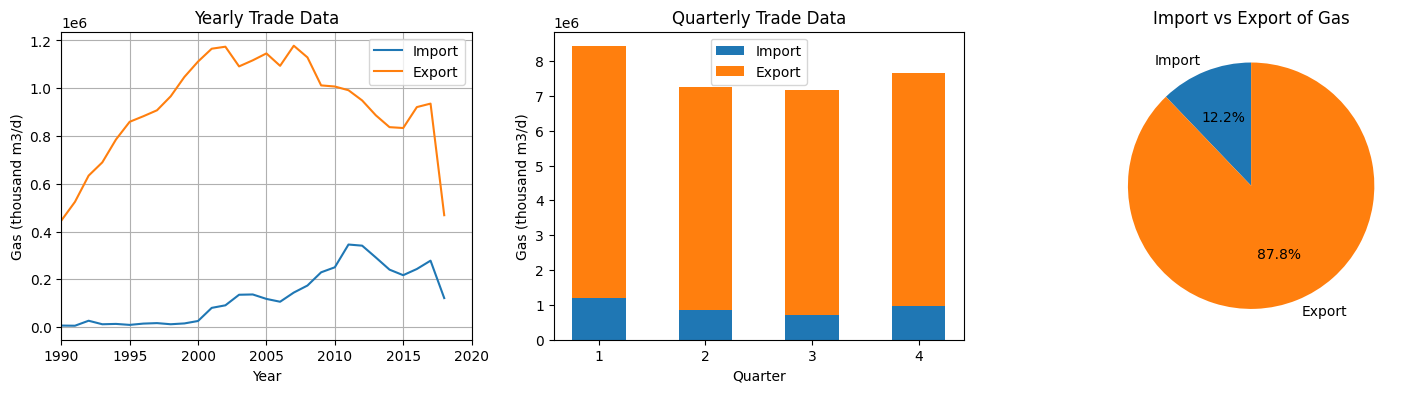

In [ ]:
volPlot('Gas','thousand m3/d')

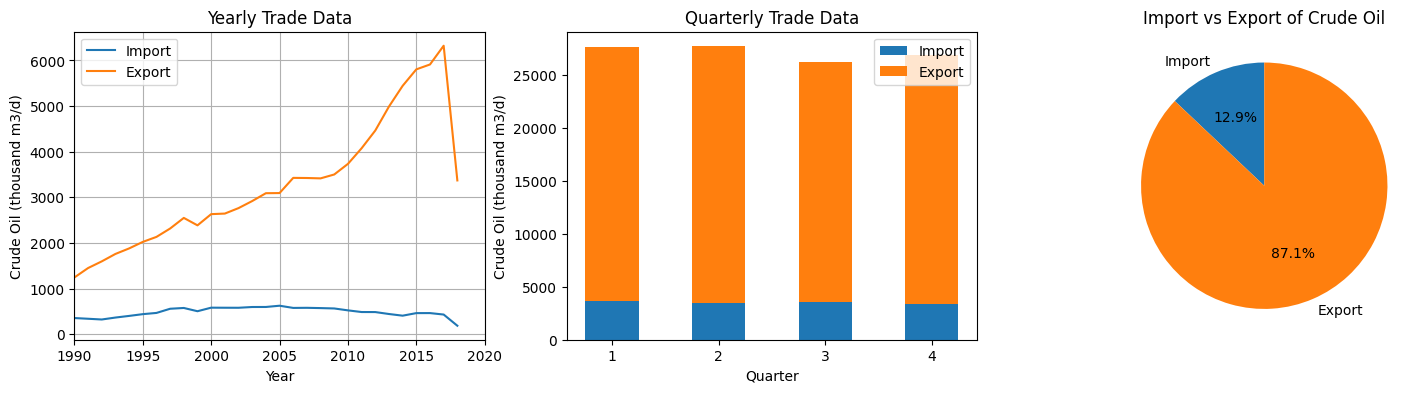

In [ ]:
volPlot('Crude Oil','thousand m3/d')

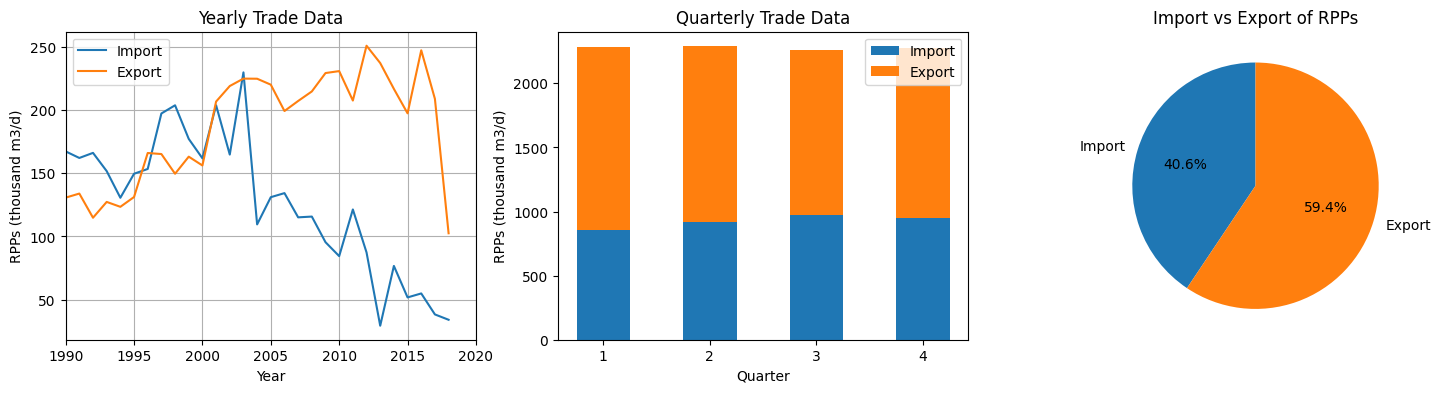

In [ ]:
volPlot('RPPs','thousand m3/d')

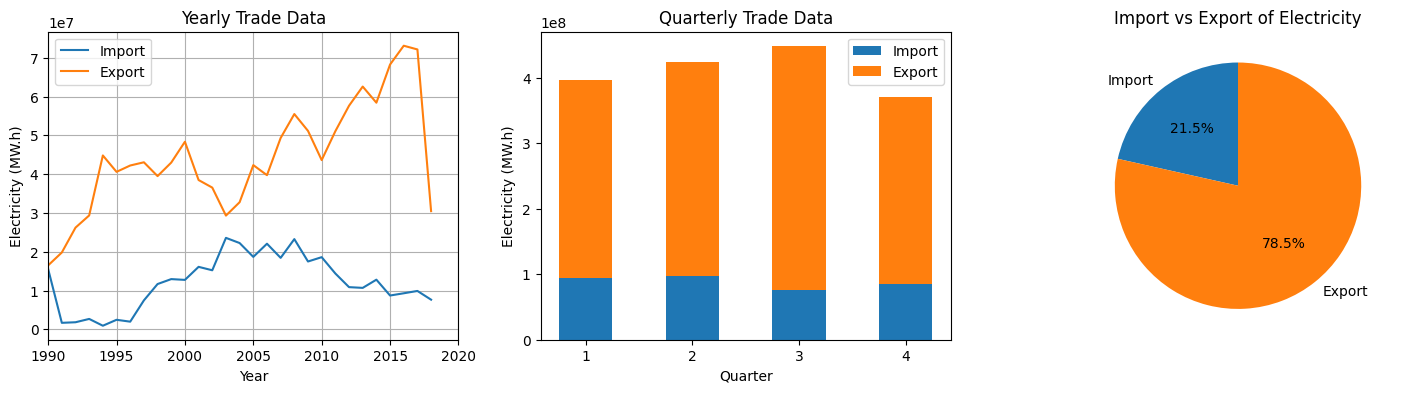

In [ ]:
volPlot('Electricity','MW.h')

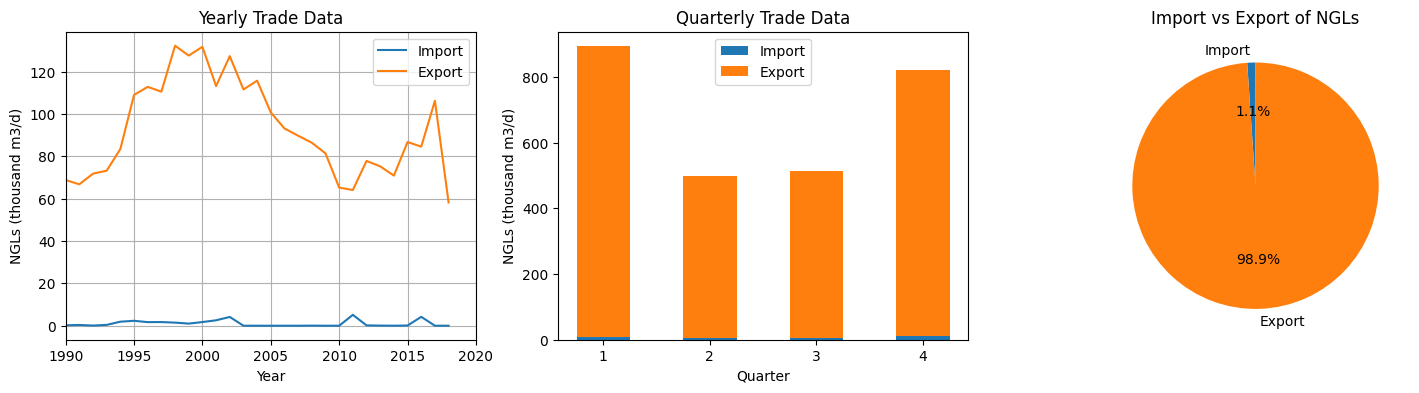

In [ ]:
volPlot('NGLs','thousand m3/d')